# Анализ информативности признаков 3D STEP-моделей

В этом ноутбуке проводится анализ информативности признаков, извлекаемых из 3D STEP-моделей. Мы рассмотрим распределения признаков, их корреляции, визуализируем пространство признаков и оценим важность с помощью простых моделей.

## 1. Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки и загрузим датасет с помощью `DatasetIO`. Также подготовим функции для работы с STEP-файлами.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier


import notebook_setup
from src.dataset import DatasetIO
from src.config import INTERIM_DATA_DIR
from src.features.brep import BrepExtractor


from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone


pkl_file = INTERIM_DATA_DIR / "dataset_metadata.pkl"
dataset = DatasetIO.load_dataset_pickle(pkl_file)

print(f"Загружено объектов: {len(dataset)}")

2025-08-14 13:53:09.945 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\3d_recognition_analisis


Project root added to path: d:\workspace\projects\freelance\3d_recognition_analisis
2025-08-14 13:53:14.231 | INFO     | src.dataset:load_dataset_pickle:332 - Загрузка датасета из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata.pkl
2025-08-14 13:53:14.234 | SUCCESS  | src.dataset:load_dataset_pickle:337 - Датасет загружен из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata.pkl
Загружено объектов: 129


## 2. Извлечение признаков для всего датасета

Применим `BrepExtractor` для извлечения векторов признаков для всех моделей в датасете. Сохраним результаты в DataFrame.

In [3]:
# Инициализация экстрактора
extractor = BrepExtractor(output_mode='pooled')

# Список для хранения результатов
feature_vectors = []
labels = []
model_ids = []

for item in dataset:
    fv = extractor.extract_single(item)
    if fv is not None:
        feature_vectors.append(fv.vector)
        labels.append(fv.label)
        model_ids.append(fv.model_id)
    else:
        # Если не удалось извлечь признаки, пропускаем объект
        print(f"Пропуск: {item.model_id}")

X = np.stack(feature_vectors)
y = np.array(labels)
model_ids = np.array(model_ids)

print("Размерность матрицы признаков:", X.shape)

2025-08-14 13:54:46.136 | INFO     | src.features.extractor:__init__:54 - Инициализация BRep экстрактора признаков на устройстве cpu
2025-08-14 13:54:46.136 | INFO     | src.features.brep:__init__:61 - Инициализация 'BRep' (K=256, LBO=16, bins=64, D=256, mode=pooled)
2025-08-14 13:54:46.214 | DEBUG    | src.features.brep:extract_single:108 - Матрица признаков 42. Ejector-01: (7, 256)
2025-08-14 13:54:46.291 | DEBUG    | src.features.brep:extract_single:108 - Матрица признаков 42. Ejector-02: (7, 256)
2025-08-14 13:54:46.374 | DEBUG    | src.features.brep:extract_single:108 - Матрица признаков 42. Ejector-03: (7, 256)
2025-08-14 13:54:46.448 | DEBUG    | src.features.brep:extract_single:108 - Матрица признаков 42. Ejector-04: (7, 256)
2025-08-14 13:54:46.516 | DEBUG    | src.features.brep:extract_single:108 - Матрица признаков 42. Ejector-05: (7, 256)
2025-08-14 13:54:46.583 | DEBUG    | src.features.brep:extract_single:108 - Матрица признаков 42. Ejector-06: (7, 256)
2025-08-14 13:54:4

In [4]:
# Преобразуем в DataFrame для удобства анализа
feature_names = [f"f_{i}" for i in range(X.shape[1])]
df_features = pd.DataFrame(X, columns=feature_names)
df_features["label"] = y
df_features["model_id"] = model_ids

# по результатам первого анализа
# Удаляем признаки: ['f_6', 'f_2', 'f_6', 'f_19', 'f_8', 'f_19', 'f_23', 'f_19', 'f_29', 'f_22', 'f_43', 'f_28', 'f_43', 'f_40', 'f_49', 'f_69', 'f_143', 'f_164', 'f_76', 'f_86', 'f_90', 'f_111', 'f_124', 'f_91', 'f_125', 'f_116', 'f_109', 'f_96', 'f_111', 'f_124', 'f_125', 'f_107', 'f_108', 'f_108', 'f_109', 'f_124', 'f_154', 'f_164', 'f_185', 'f_158', 'f_171', 'f_146', 'f_163', 'f_151', 'f_154', 'f_188', 'f_171', 'f_185', 'f_168', 'f_188', 'f_196', 'f_196', 'f_202', 'f_195', 'f_208', 'f_216', 'f_216', 'f_224', 'f_217', 'f_216', 'f_208', 'f_224', 'f_229', 'f_210', 'f_219', 'f_216', 'f_224', 'f_229', 'f_227', 'f_220', 'f_229', 'f_234', 'f_227', 'f_230', 'f_229', 'f_232', 'f_237', 'f_232', 'f_235', 'f_240', 'f_234', 'f_237', 'f_229', 'f_238', 'f_231', 'f_237', 'f_240', 'f_234', 'f_240', 'f_235', 'f_238', 'f_240', 'f_248', 'f_248', 'f_247', 'f_244', 'f_247', 'f_323', 'f_329', 'f_481', 'f_492', 'f_494', 'f_495', 'f_494', 'f_495', 'f_497', 'f_498', 'f_497', 'f_498', 'f_498', 'f_500', 'f_499', 'f_502', 'f_500', 'f_502', 'f_502', 'f_504']

# df_features = df_features.drop(columns=[
#     'f_6', 'f_2', 'f_6', 'f_19', 'f_8', 'f_19', 'f_23', 'f_19', 'f_29', 'f_22', 'f_43', 'f_28', 'f_43', 'f_40', 'f_49', 'f_69', 'f_143', 'f_164', 'f_76', 'f_86', 'f_90', 'f_111', 'f_124', 'f_91', 'f_125', 'f_116', 'f_109', 'f_96', 'f_111', 'f_124', 'f_125', 'f_107', 'f_108', 'f_108', 'f_109', 'f_124', 'f_154', 'f_164', 'f_185', 'f_158', 'f_171', 'f_146', 'f_163', 'f_151', 'f_154', 'f_188', 'f_171', 'f_185', 'f_168', 'f_188', 'f_196', 'f_196', 'f_202', 'f_195', 'f_208', 'f_216', 'f_216', 'f_224', 'f_217', 'f_216', 'f_208', 'f_224', 'f_229', 'f_210', 'f_219', 'f_216', 'f_224', 'f_229', 'f_227', 'f_220', 'f_229', 'f_234', 'f_227', 'f_230', 'f_229', 'f_232', 'f_237', 'f_232', 'f_235', 'f_240', 'f_234', 'f_237', 'f_229', 'f_238', 'f_231', 'f_237', 'f_240', 'f_234', 'f_240', 'f_235', 'f_238', 'f_240', 'f_248', 'f_248', 'f_247', 'f_244', 'f_247', 'f_323', 'f_329', 'f_481', 'f_492', 'f_494', 'f_495', 'f_494', 'f_495', 'f_497', 'f_498', 'f_497', 'f_498', 'f_498', 'f_500', 'f_499', 'f_502', 'f_500', 'f_502', 'f_502', 'f_504'
# ])

# feature_names = df_features.columns.tolist()
print('Shape vector:', df_features.shape)
df_features.head()

Shape vector: (129, 258)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_248,f_249,f_250,f_251,f_252,f_253,f_254,f_255,label,model_id
0,1.361038,1.513968,1.666899,1.819829,1.972760,2.125920,2.279091,2.432262,2.585433,2.738727,...,14.392488,12.348668,10.304851,8.260549,6.206505,4.152465,2.098433,0.044436,42. Ejector,42. Ejector-01
1,1.350136,1.500724,1.651312,1.801900,1.952488,2.103246,2.254012,2.404778,2.555544,2.706311,...,14.534660,12.469678,10.404700,8.339515,6.270117,4.200725,2.131355,0.062079,42. Ejector,42. Ejector-02
2,1.352942,1.506013,1.659084,1.812156,1.965227,2.118504,2.271792,2.425080,2.578367,2.731584,...,14.801015,12.694067,10.587127,8.480287,6.375378,4.270475,2.165594,0.060807,42. Ejector,42. Ejector-03
3,1.363914,1.519335,1.674756,1.830178,1.985599,2.141636,2.297704,2.453771,2.609839,2.765412,...,14.459054,12.399126,10.339198,8.279305,6.220020,4.160738,2.101463,0.042222,42. Ejector,42. Ejector-04
4,1.381275,1.537277,1.693278,1.849279,2.005280,2.161642,2.318022,2.474401,2.630781,2.787034,...,14.593376,12.520862,10.448349,8.375345,6.292507,4.209670,2.126843,0.044055,42. Ejector,42. Ejector-05


## 3. Анализ распределения каждого признака

Построим гистограммы и boxplot для отдельных признаков и групп признаков, чтобы оценить их вариативность и выявить константные или аномальные признаки.

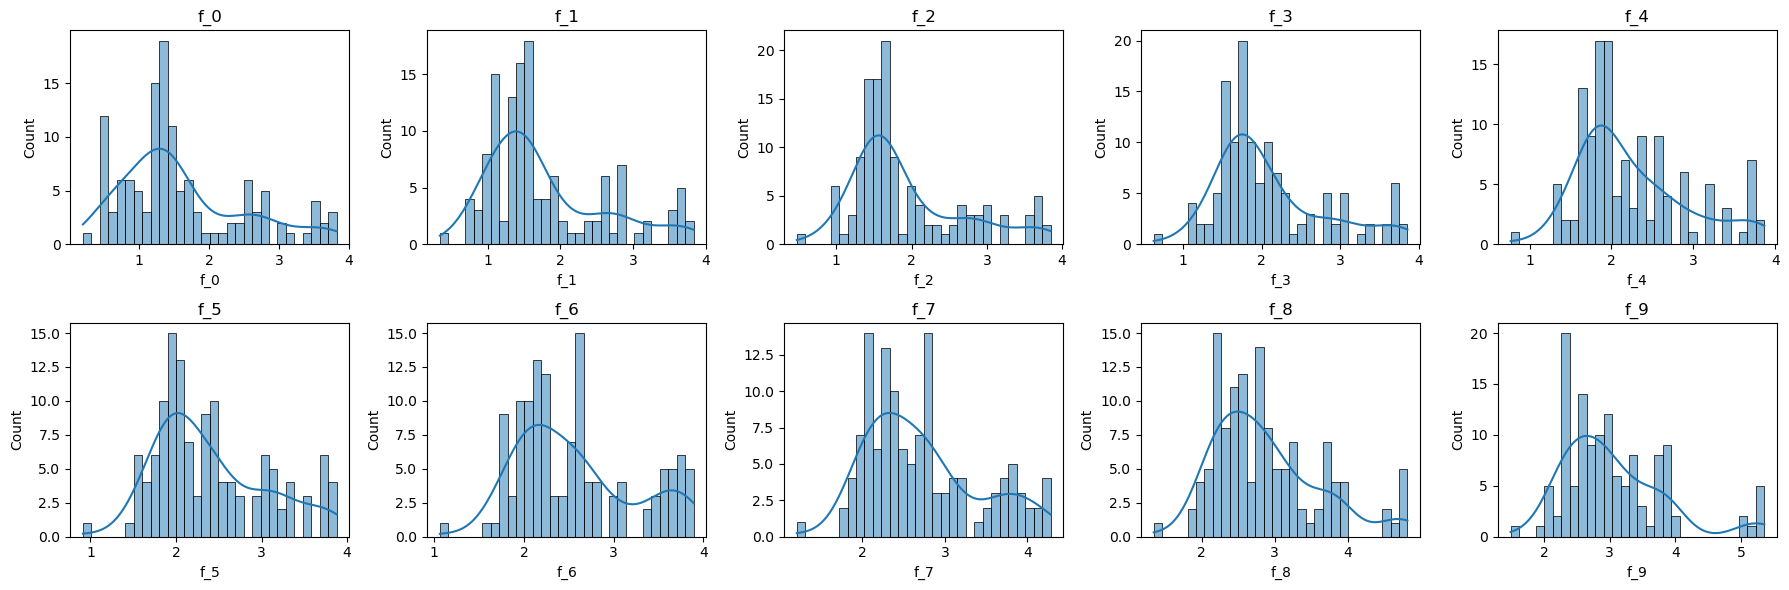

In [5]:
# Гистограммы для первых 10 признаков
df = df_features.iloc[:, :10]  
fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for (i, ax) in enumerate(axes.flat):
    sns.histplot(data=df.iloc[:, i], bins=30, ax=ax, kde=True)
    ax.set_title(df.columns[i])
plt.tight_layout()
plt.show()

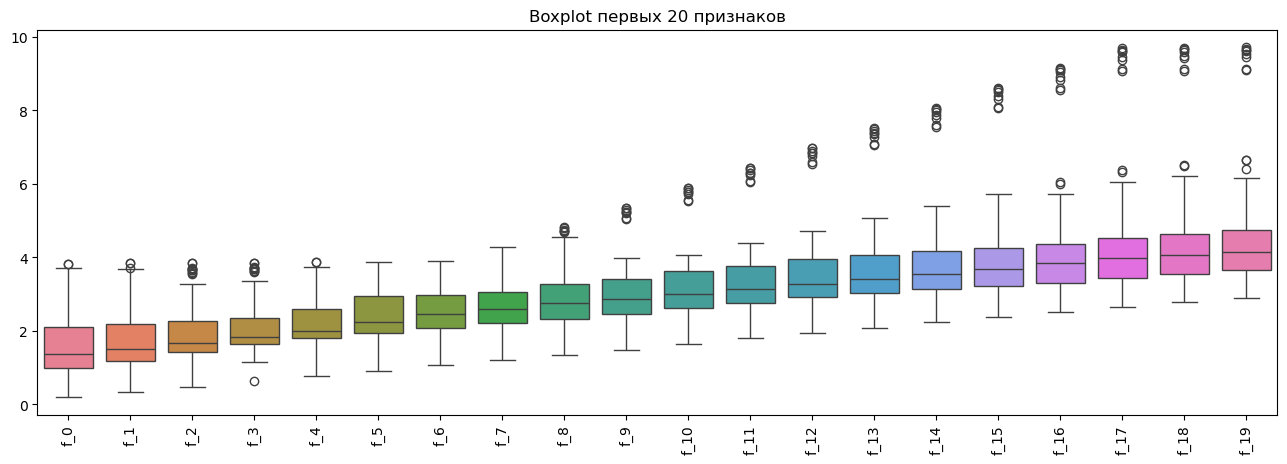

In [6]:
# Boxplot для первых 20 признаков
df = df_features.iloc[:, :20]
plt.figure(figsize=(16, 5))

sns.boxplot(data=df)
plt.title("Boxplot первых 20 признаков")
plt.xticks(rotation=90)
plt.show()

In [7]:
# Проверим на константные признаки
const_mask = df_features[feature_names].nunique() == 1
const_features = np.array(feature_names)[const_mask.values]
print("Константные признаки:", const_features.tolist())

Константные признаки: []


## 4. Оценка корреляции между признаками

Вычислим корреляционную матрицу между признаками и визуализируем её с помощью heatmap. Это поможет выявить дублирующие (сильно коррелирующие) признаки.

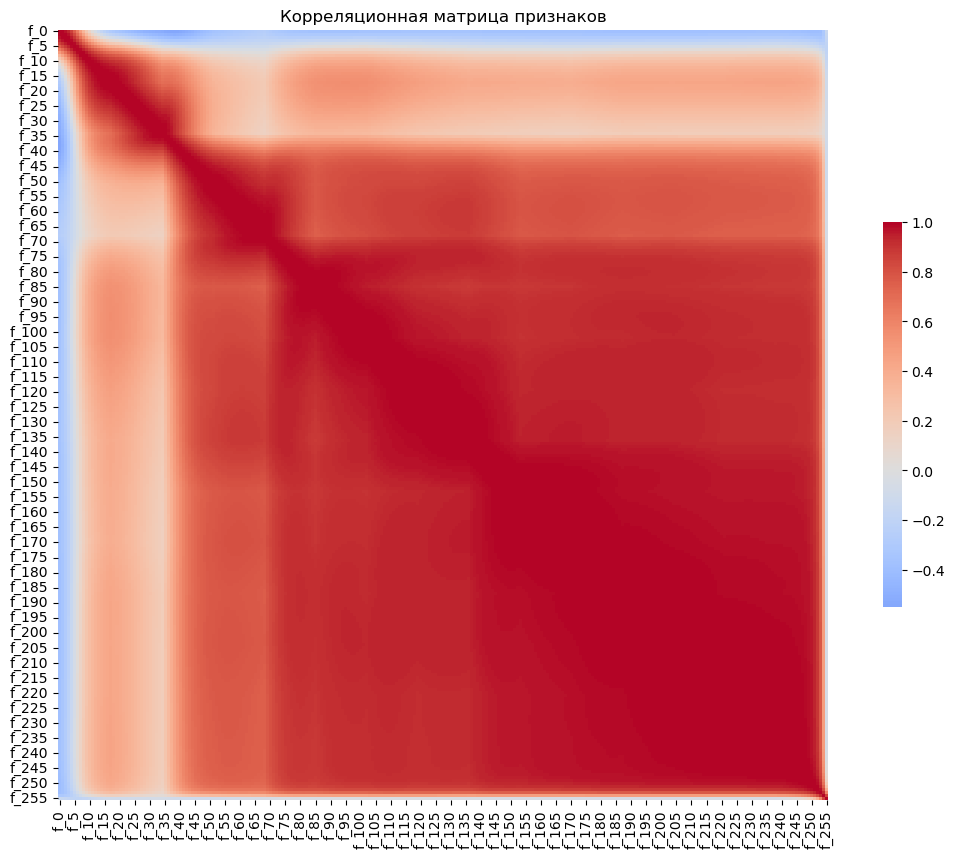

In [8]:
# Корреляционная матрица
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()
corr = df_features[numeric_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .5})
plt.title("Корреляционная матрица признаков")
plt.show()

In [10]:
# Найдем пары признаков с сильной корреляцией (> 0.95)
high_corr = np.where(np.abs(corr.values) > 0.95)
high_corr_pairs = [
    (numeric_features[i], numeric_features[j])
    for i, j in zip(*high_corr)
    if i != j and i < j
]
print("Пары сильно коррелирующих признаков:", high_corr_pairs)
print(f"Количество пар сильно коррелирующих признаков: {len(high_corr_pairs)}")

Пары сильно коррелирующих признаков: [('f_0', 'f_1'), ('f_0', 'f_2'), ('f_1', 'f_2'), ('f_1', 'f_3'), ('f_2', 'f_3'), ('f_2', 'f_4'), ('f_3', 'f_4'), ('f_4', 'f_5'), ('f_5', 'f_6'), ('f_6', 'f_7'), ('f_7', 'f_8'), ('f_7', 'f_9'), ('f_8', 'f_9'), ('f_8', 'f_10'), ('f_9', 'f_10'), ('f_9', 'f_11'), ('f_9', 'f_12'), ('f_10', 'f_11'), ('f_10', 'f_12'), ('f_10', 'f_13'), ('f_10', 'f_14'), ('f_11', 'f_12'), ('f_11', 'f_13'), ('f_11', 'f_14'), ('f_11', 'f_15'), ('f_11', 'f_16'), ('f_12', 'f_13'), ('f_12', 'f_14'), ('f_12', 'f_15'), ('f_12', 'f_16'), ('f_12', 'f_17'), ('f_12', 'f_18'), ('f_12', 'f_19'), ('f_13', 'f_14'), ('f_13', 'f_15'), ('f_13', 'f_16'), ('f_13', 'f_17'), ('f_13', 'f_18'), ('f_13', 'f_19'), ('f_13', 'f_20'), ('f_14', 'f_15'), ('f_14', 'f_16'), ('f_14', 'f_17'), ('f_14', 'f_18'), ('f_14', 'f_19'), ('f_14', 'f_20'), ('f_14', 'f_21'), ('f_15', 'f_16'), ('f_15', 'f_17'), ('f_15', 'f_18'), ('f_15', 'f_19'), ('f_15', 'f_20'), ('f_15', 'f_21'), ('f_15', 'f_22'), ('f_16', 'f_17'), ('

## 5. Визуализация признаков с помощью снижения размерности (PCA/t-SNE)

Применим методы снижения размерности (PCA и t-SNE) для визуализации распределения объектов в пространстве признаков. Отобразим результаты на scatter plot, раскрасив по классам.

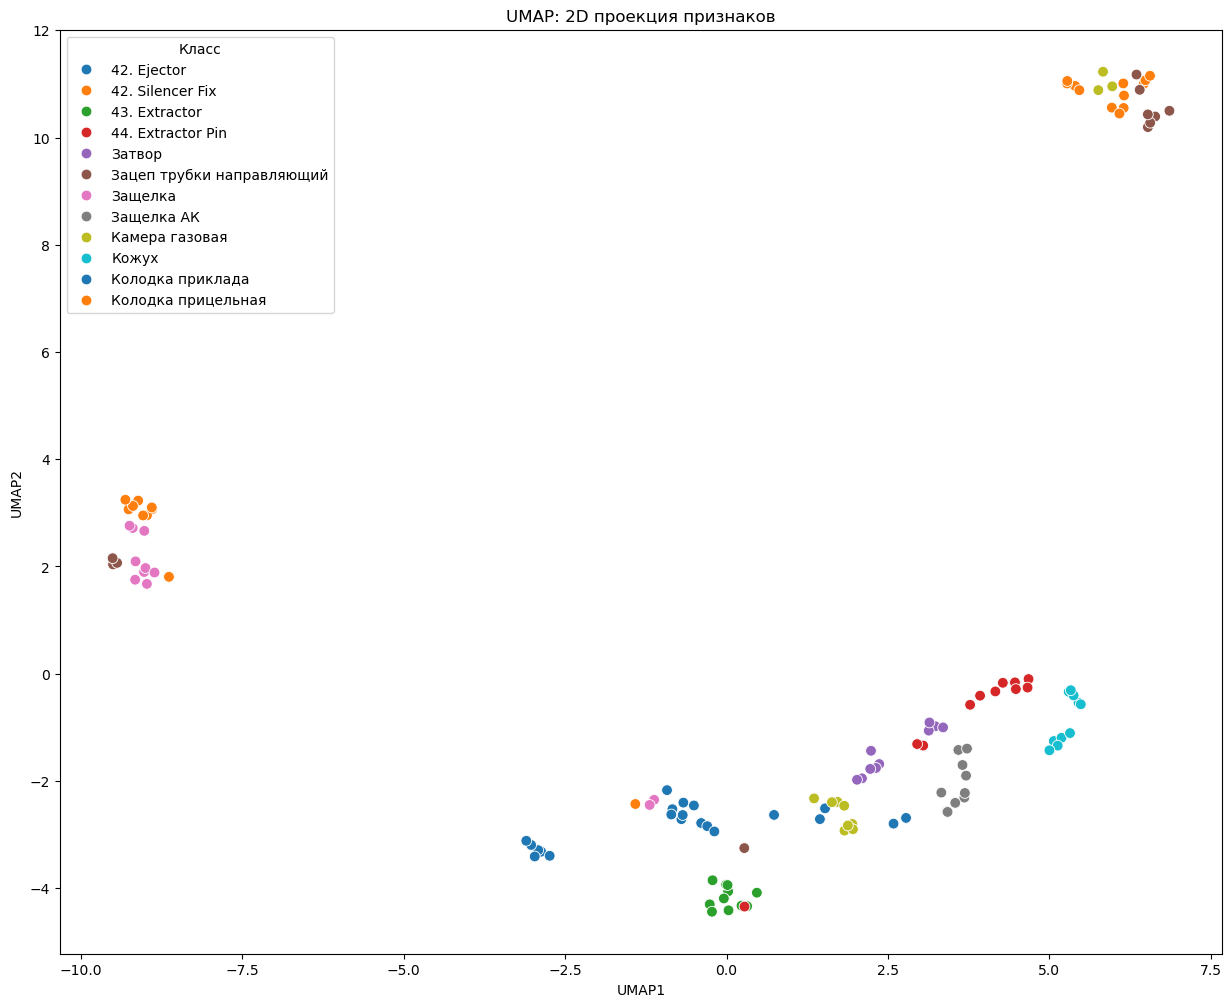

In [11]:
from sklearn.preprocessing import StandardScaler
import umap

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(15, 12))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="tab10", s=60)
plt.title("UMAP: 2D проекция признаков")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Класс")
plt.show()

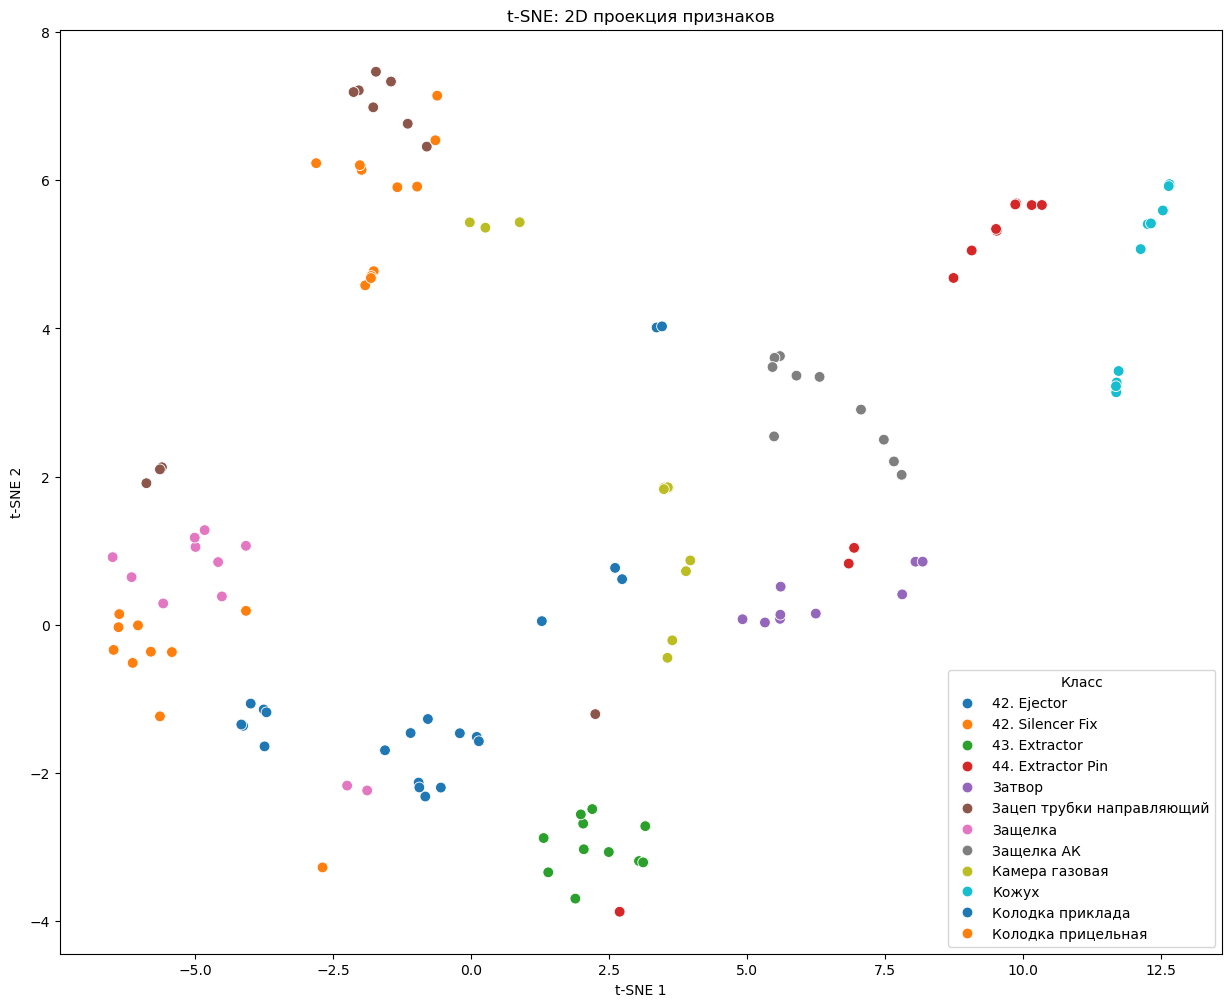

In [12]:
# t-SNE 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(15, 12))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", s=60)
plt.title("t-SNE: 2D проекция признаков")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Класс")
plt.show()

## 6. Оценка важности признаков с помощью простых моделей (например, RandomForest)

Обучим простую модель (RandomForestClassifier) на признаках и оценим важность каждого признака. Визуализируем топ-важные признаки.

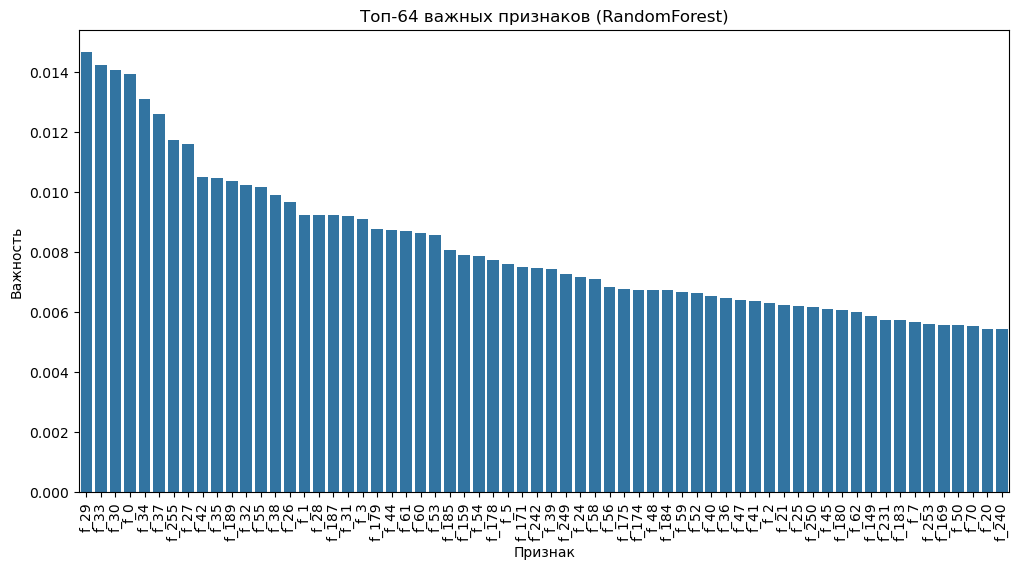

In [13]:
# Обучение RandomForest для оценки важности признаков
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled, y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация топ-n признаков
top_n = min(64, len(feature_names))
top_indices = [i for i in indices if i < len(feature_names)][:top_n]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=[feature_names[i] for i in top_indices],
    y=importances[top_indices]
)
plt.title(f"Топ-{top_n} важных признаков (RandomForest)")
plt.ylabel("Важность")
plt.xlabel("Признак")
plt.xticks(rotation=90)
plt.show()

# 7. Получим список признаков для удаления

Это выполнить необходимо при первой итерации исследования. Мы извлекаем из пар менее важный признак и помечаем его для удаления.

Если список пуст, то можно приступать к кросс-валидации

In [14]:
# Получаем важности признаков
importances_dict = dict(zip(feature_names, importances))

to_drop = []
for f1, f2 in high_corr_pairs:
    if importances_dict.get(f1, 0) >= importances_dict.get(f2, 0):
        to_drop.append(f2)
    else:
        to_drop.append(f1)

print("Удаляем признаки:", to_drop)


Удаляем признаки: ['f_1', 'f_2', 'f_2', 'f_3', 'f_2', 'f_4', 'f_4', 'f_4', 'f_6', 'f_6', 'f_8', 'f_9', 'f_8', 'f_8', 'f_10', 'f_11', 'f_12', 'f_11', 'f_10', 'f_13', 'f_14', 'f_11', 'f_11', 'f_14', 'f_11', 'f_11', 'f_13', 'f_14', 'f_12', 'f_16', 'f_17', 'f_12', 'f_19', 'f_14', 'f_13', 'f_13', 'f_13', 'f_13', 'f_13', 'f_13', 'f_14', 'f_14', 'f_14', 'f_14', 'f_14', 'f_14', 'f_14', 'f_16', 'f_17', 'f_15', 'f_19', 'f_15', 'f_15', 'f_22', 'f_16', 'f_16', 'f_16', 'f_16', 'f_16', 'f_22', 'f_16', 'f_17', 'f_17', 'f_17', 'f_17', 'f_22', 'f_23', 'f_19', 'f_18', 'f_18', 'f_22', 'f_23', 'f_18', 'f_19', 'f_19', 'f_22', 'f_23', 'f_19', 'f_19', 'f_20', 'f_22', 'f_23', 'f_20', 'f_20', 'f_20', 'f_22', 'f_23', 'f_21', 'f_25', 'f_21', 'f_21', 'f_22', 'f_22', 'f_22', 'f_22', 'f_22', 'f_22', 'f_23', 'f_23', 'f_23', 'f_23', 'f_23', 'f_23', 'f_25', 'f_24', 'f_24', 'f_24', 'f_24', 'f_24', 'f_25', 'f_25', 'f_25', 'f_25', 'f_25', 'f_25', 'f_26', 'f_28', 'f_26', 'f_26', 'f_31', 'f_26', 'f_28', 'f_27', 'f_27', 'f_

# 8. Кросс-валидация

Оцениваем качество модели на разных подвыборках данных, чтобы избежать переобучения и получить честную оценку.

n_neighbors=1: mean accuracy=0.9148 ± 0.0509
n_neighbors=2: mean accuracy=0.8914 ± 0.0450
n_neighbors=3: mean accuracy=0.8674 ± 0.0740
n_neighbors=4: mean accuracy=0.8212 ± 0.0642
n_neighbors=5: mean accuracy=0.7745 ± 0.0775
n_neighbors=6: mean accuracy=0.7591 ± 0.0597
n_neighbors=7: mean accuracy=0.7514 ± 0.0603
n_neighbors=8: mean accuracy=0.7277 ± 0.0740
n_neighbors=9: mean accuracy=0.7123 ± 0.0630
n_neighbors=10: mean accuracy=0.7043 ± 0.0948
n_neighbors=11: mean accuracy=0.6658 ± 0.0833
n_neighbors=12: mean accuracy=0.6188 ± 0.1163
n_neighbors=13: mean accuracy=0.5806 ± 0.0830
n_neighbors=14: mean accuracy=0.5498 ± 0.0956
n_neighbors=15: mean accuracy=0.5345 ± 0.0577
n_neighbors=16: mean accuracy=0.5498 ± 0.0567
n_neighbors=17: mean accuracy=0.5037 ± 0.0792
n_neighbors=18: mean accuracy=0.5037 ± 0.0714
n_neighbors=19: mean accuracy=0.5040 ± 0.0846
n_neighbors=20: mean accuracy=0.5111 ± 0.0667


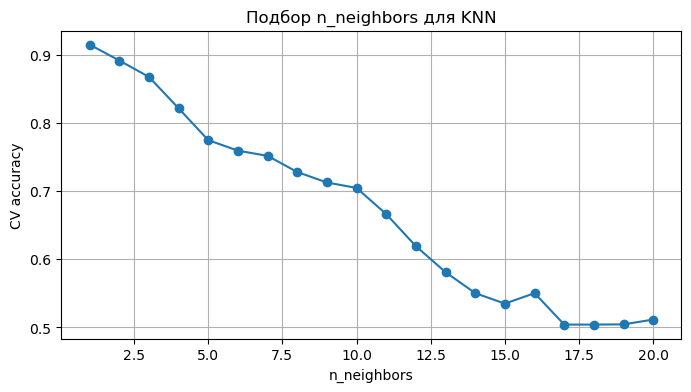

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

neighbors_range = range(1, 21)
cv_scores = []

for k in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"n_neighbors={k}: mean accuracy={scores.mean():.4f} ± {scores.std():.4f}")

# Визуализация зависимости accuracy от n_neighbors
plt.figure(figsize=(8, 4))
plt.plot(neighbors_range, cv_scores, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('CV accuracy')
plt.title('Подбор n_neighbors для KNN')
plt.grid(True)
plt.show()

обучение и анализ ошибок

Test accuracy: 0.9487179487179487
Test F1 (weighted): 0.9475783475783476


Text(0.5, 58.6440972222222, 'Предсказанные классы')

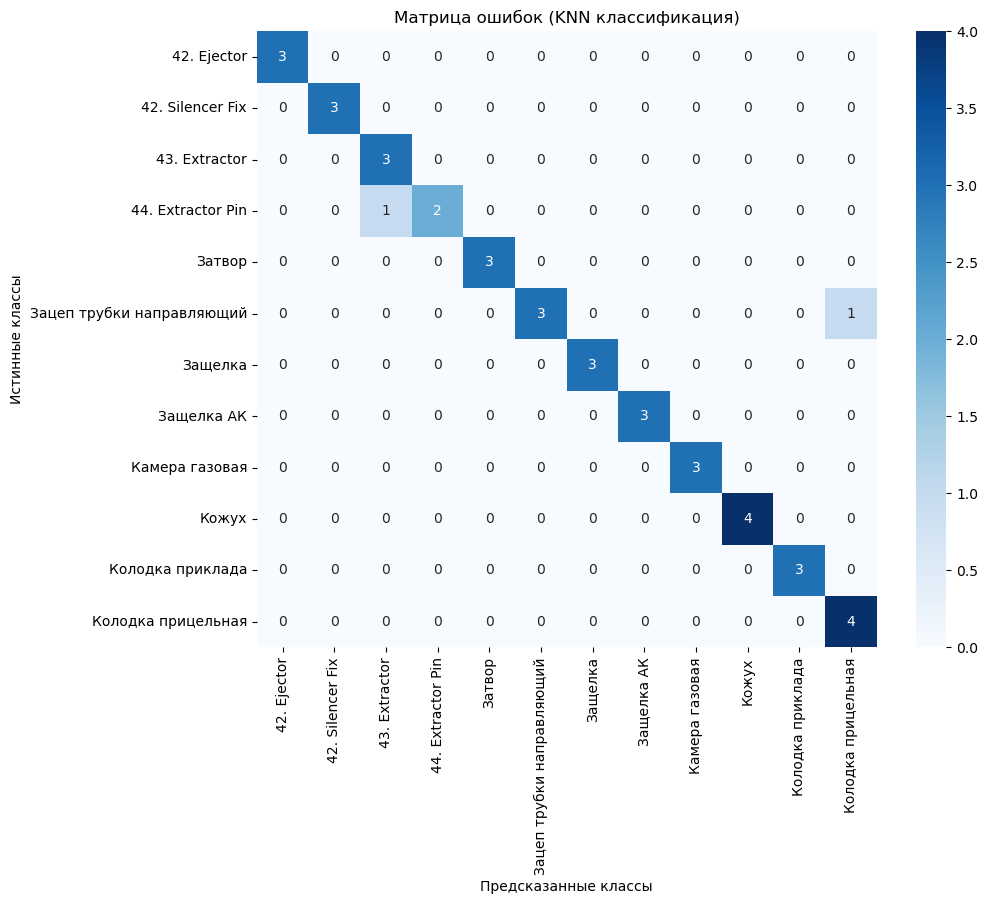

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Обучаем модель на обучающей выборке
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

# Оцениваем на тестовой выборке
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification report:\n", classification_report(y_test, y_pred))
unique_labels = np.unique(y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.title('Матрица ошибок (KNN классификация)')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

val_indices = []
train_indices = []
class_counter = defaultdict(int)

for idx, label in enumerate(y):
    if class_counter[label] < 3:
        val_indices.append(idx)
        class_counter[label] += 1
    else:
        train_indices.append(idx)

X_train = X_scaled[train_indices]
y_train = y[train_indices]
X_val = X_scaled[val_indices]
y_val = y[val_indices]

le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_int, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Train size: 93, Val size: 36


In [23]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# ----------------- Building Blocks -----------------

class ConvBNAct1d(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, d=1, groups=1, act=True):
        super().__init__()
        p = (k // 2) * d
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p,
                              dilation=d, groups=groups, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.SiLU(inplace=True) if act else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class SqueezeExcite1d(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        hidden = max(1, ch // r)
        self.fc1 = nn.Conv1d(ch, hidden, kernel_size=1)
        self.fc2 = nn.Conv1d(hidden, ch, kernel_size=1)

    def forward(self, x):
        # x: (B, C, L)
        w = F.adaptive_avg_pool1d(x, 1)                  # (B, C, 1)
        w = F.silu(self.fc1(w))
        w = torch.sigmoid(self.fc2(w))
        return x * w


class DWSeparableBlock1d(nn.Module):
    """Depthwise → Pointwise (+ SE), с резидуалом и dropout."""
    def __init__(self, ch, k=5, d=1, drop=0.1, use_se=True):
        super().__init__()
        self.dw = ConvBNAct1d(ch, ch, k=k, d=d, groups=ch)     # depthwise
        self.pw = ConvBNAct1d(ch, ch, k=1)
        self.se = SqueezeExcite1d(ch) if use_se else nn.Identity()
        self.drop = nn.Dropout1d(p=drop) if drop and drop > 0 else nn.Identity()

    def forward(self, x):
        out = self.dw(x)
        out = self.pw(out)
        out = self.se(out)
        out = self.drop(out)
        return x + out


class DownsampleBlock1d(nn.Module):
    """Сжимает длину в 2 раза и увеличивает каналы (residual)."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = ConvBNAct1d(in_ch, out_ch, k=3, s=2)  # stride-2
        self.res  = ConvBNAct1d(in_ch, out_ch, k=1, s=2, act=False)

    def forward(self, x):
        return self.conv(x) + self.res(x)


# ----------------- Model -----------------

class CNN1D_Backbone(nn.Module):
    """
    Бекбон для 1D признаков (B, 7, L).
    Структура (пример для L=256):
      stem:    7 → 32 (L)
      stage1:  32 → 64 (L/2)
      stage2:  64 → 128 (L/4)
      stage3:  128→ 256 (L/8)
    На каждом стейдже 2 DW-сепарабельных блока с разными диляциями.
    """
    def __init__(self, in_ch=7, c_stem=32, widths=(64, 128, 256), drop=0.1, use_se=True):
        super().__init__()
        self.stem = ConvBNAct1d(in_ch, c_stem, k=7)

        stages = []
        c_prev = c_stem
        for c in widths:
            stages += [DownsampleBlock1d(c_prev, c)]
            # два блока: локальный (d=1) и более «широкий» контекст (d=2)
            stages += [DWSeparableBlock1d(c, k=5, d=1, drop=drop, use_se=use_se),
                       DWSeparableBlock1d(c, k=5, d=2, drop=drop, use_se=use_se)]
            c_prev = c
        self.stages = nn.Sequential(*stages)
        self.out_ch = widths[-1]

        # лёгкая регуляризация на фичах бэкбона
        self.head_norm = nn.BatchNorm1d(self.out_ch)

    def forward(self, x):
        x = self.stem(x)
        x = self.stages(x)
        x = self.head_norm(x)
        return x   # (B, C_out, L_out)


class CNN1D(nn.Module):
    """
    Универсальная модель:
      - принимает (B, 7, L) (L произвольной длины),
      - выдаёт эмбеддинг emb_dim (по умолчанию 256),
      - при num_classes>0 — логиты для классификации.
    """
    def __init__(self, in_ch=7, emb_dim=256, num_classes=0,
                 c_stem=32, widths=(64,128,256), drop=0.1, use_se=True):
        super().__init__()
        self.backbone = CNN1D_Backbone(in_ch, c_stem, widths, drop, use_se)
        self.pool = nn.AdaptiveAvgPool1d(1)   # длина → 1
        self.embed = nn.Sequential(
            nn.Conv1d(self.backbone.out_ch, emb_dim, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dim),
            nn.SiLU(inplace=True)
        )
        self.num_classes = int(num_classes)
        self.classifier = nn.Linear(emb_dim, self.num_classes) if self.num_classes > 0 else None

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='silu')
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02); nn.init.zeros_(m.bias)

    def forward(self, x, return_embedding=True):
        """
        x: (B, 7, L) — из экстрактора с mode='matrix'
        return:
          logits (если num_classes>0) и/или emb (B, emb_dim)
        """
        f = self.backbone(x)                  # (B, C, L')
        f = self.pool(f)                      # (B, C, 1)
        f = self.embed(f).squeeze(-1)         # (B, emb_dim)

        logits = self.classifier(f) if self.classifier is not None else None
        if logits is not None and return_embedding:
            return logits, F.normalize(f, dim=1)
        if logits is not None:
            return logits
        return F.normalize(f, dim=1)


# ----------------- Factory helpers -----------------

def build_cnn1d_small(num_classes=0, emb_dim=256):
    # чуть легче и быстрее
    return CNN1D(in_ch=7, emb_dim=emb_dim, num_classes=num_classes,
                 c_stem=24, widths=(48, 96, 192), drop=0.05, use_se=True)

def build_cnn1d_base(num_classes=0, emb_dim=256):
    # рекомендованный базовый
    return CNN1D(in_ch=7, emb_dim=emb_dim, num_classes=num_classes,
                 c_stem=32, widths=(64, 128, 256), drop=0.10, use_se=True)

def build_cnn1d_plus(num_classes=0, emb_dim=256):
    # погуще каналы — если есть запас по GPU
    return CNN1D(in_ch=7, emb_dim=emb_dim, num_classes=num_classes,
                 c_stem=48, widths=(96, 192, 384), drop=0.10, use_se=True)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualMLPBlock(nn.Module):
    def __init__(self, dim: int, mult: int = 2, drop: float = 0.2):
        super().__init__()
        hid = dim * mult
        self.fc1 = nn.Linear(dim, hid, bias=False)
        self.bn1 = nn.BatchNorm1d(hid)
        self.fc2 = nn.Linear(hid, dim, bias=False)
        self.bn2 = nn.BatchNorm1d(dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        # x: (B, D)
        y = self.fc1(x)
        y = F.silu(self.bn1(y))
        y = self.drop(y)
        y = self.fc2(y)
        y = self.bn2(y)
        return F.silu(x + y)

class PooledMLP(nn.Module):
    """
    Классификатор для эмбеддингов из экстрактора (B, D).
    По умолчанию ожидает D=256, но работает с любым D.
    """
    def __init__(self, in_dim: int, num_classes: int, width: int = 256, depth: int = 2, drop: float = 0.2):
        super().__init__()
        self.in_norm = nn.BatchNorm1d(in_dim)
        self.in_proj = nn.Linear(in_dim, width, bias=False)
        self.in_bn   = nn.BatchNorm1d(width)
        self.in_act  = nn.SiLU(inplace=True)
        self.in_drop = nn.Dropout(drop)

        blocks = [ResidualMLPBlock(width, mult=2, drop=drop) for _ in range(depth)]
        self.blocks = nn.Sequential(*blocks)

        self.head = nn.Sequential(
            nn.Linear(width, width, bias=False),
            nn.BatchNorm1d(width),
            nn.SiLU(inplace=True)
        )
        self.classifier = nn.Linear(width, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='silu')
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm1d,)):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):                    # x: (B, D)
        x = self.in_norm(x)
        x = self.in_proj(x)
        x = self.in_bn(x)
        x = self.in_act(x)
        x = self.in_drop(x)
        x = self.blocks(x)
        x = self.head(x)
        logits = self.classifier(x)          # (B, C)
        return logits

In [27]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # График потерь (Loss)
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('График потерь (Loss)')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Потери')
    ax1.legend()
    ax1.grid(True)

    # График точности (Accuracy)
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('График точности (Accuracy)')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Точность')
    ax2.legend()
    ax2.grid(True)

    plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
from tqdm.notebook import tqdm 
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = X_train_tensor.shape[1]                 # размер эмбеддинга из экстрактора (обычно 256)
num_classes = len(le.classes_)

# Если классы несбалансированы, добавим веса
import numpy as np
cls_counts = np.bincount(y_train_int)
cls_weights = (1.0 / np.clip(cls_counts, 1, None))
cls_weights = cls_weights * (len(cls_weights) / cls_weights.sum())
cls_weights_t = torch.tensor(cls_weights, dtype=torch.float32, device=device)

model = PooledMLP(in_dim=in_dim, num_classes=num_classes, width=256, depth=2, drop=0.2).to(device)

criterion = nn.CrossEntropyLoss(
    weight=cls_weights_t,          # можно убрать, если классы ровные
    label_smoothing=0.10           # сглаживание меток помогает на малых выборках
)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

num_epochs = 100
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'lr': []
}


# Early Stopping
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 10
best_model_state = None

epoch_bar = tqdm(range(num_epochs), desc="Обучение", unit="эпоха")

for epoch in epoch_bar:
    # === ОБУЧЕНИЕ ===
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    
    # === ВАЛИДАЦИЯ ===
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = accuracy_score(all_labels, all_preds)
    
    # ВАЖНО: scheduler получает val_loss, а не train_loss
    scheduler.step(epoch_val_loss)
    
    # Сохраняем текущий learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Обновляем историю
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    history['lr'].append(current_lr)
    
    # Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Сохраняем лучшую модель
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_geometry_model.pth')
    else:
        patience_counter += 1
        
    # Обновляем progress bar
    epoch_bar.set_postfix(
        train_loss=f"{epoch_train_loss:.4f}",
        train_acc=f"{epoch_train_acc:.4f}",
        val_loss=f"{epoch_val_loss:.4f}",
        val_acc=f"{epoch_val_acc:.4f}",
        lr=f"{current_lr:.6f}",
        patience=f"{patience_counter}/{early_stop_patience}"
    )
    
    # Early stopping
    # if patience_counter >= early_stop_patience:
    #     print(f"\n🛑 Early stopping на эпохе {epoch + 1}")
    #     break
    
    # Останавливаем если LR стал слишком маленьким
    if current_lr < 1e-7:
        print(f"\n⏰ Learning rate слишком мал: {current_lr:.2e}. Остановка.")
        break

# Загружаем лучшую модель для итогового отчета
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("📦 Загружена лучшая модель для финального тестирования")

# === ФИНАЛЬНАЯ ВАЛИДАЦИЯ ===
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        final_preds.extend(predicted.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

print("\n" + "="*70)
print("📊 ФИНАЛЬНЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ (лучшая модель)")
print("="*70)
print(classification_report(final_labels, final_preds, zero_division=0))
print("="*70)

# Анализ обучения
print(f"\n📈 СВОДКА ОБУЧЕНИЯ:")
print(f"Лучший val_loss: {best_val_loss:.4f}")
print(f"Финальный learning rate: {history['lr'][-1]:.2e}")
print(f"Снижений LR: {len([i for i in range(1, len(history['lr'])) if history['lr'][i] < history['lr'][i-1]])}")

ValueError: Unsupported nonlinearity silu

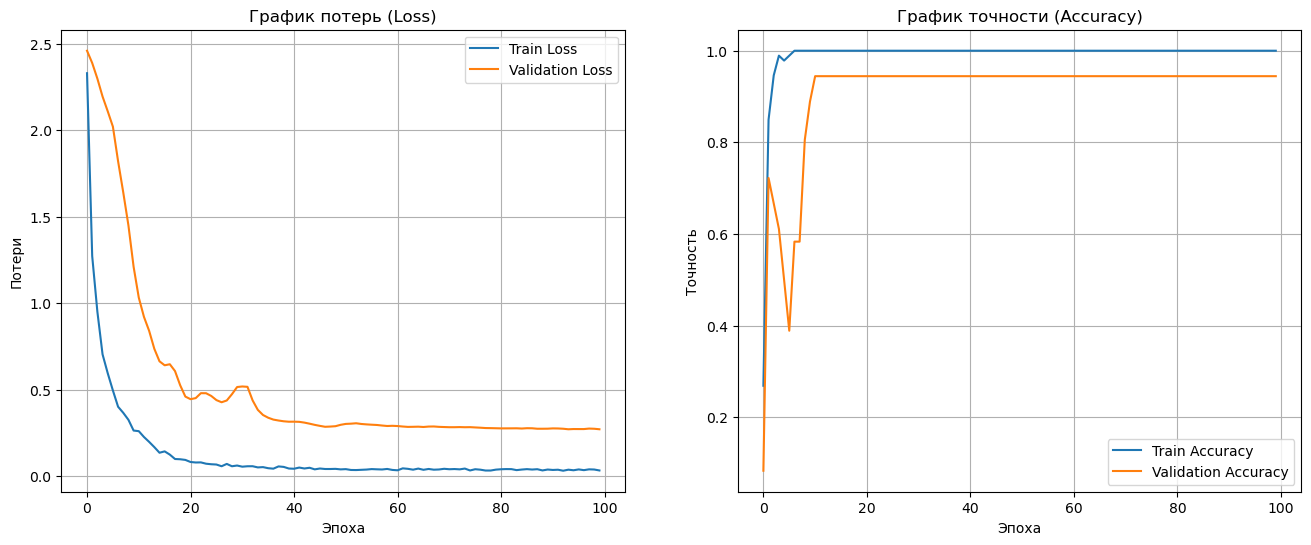

In [84]:
plot_history(history)

Test accuracy: 0.9444
Test F1 (weighted): 0.9345


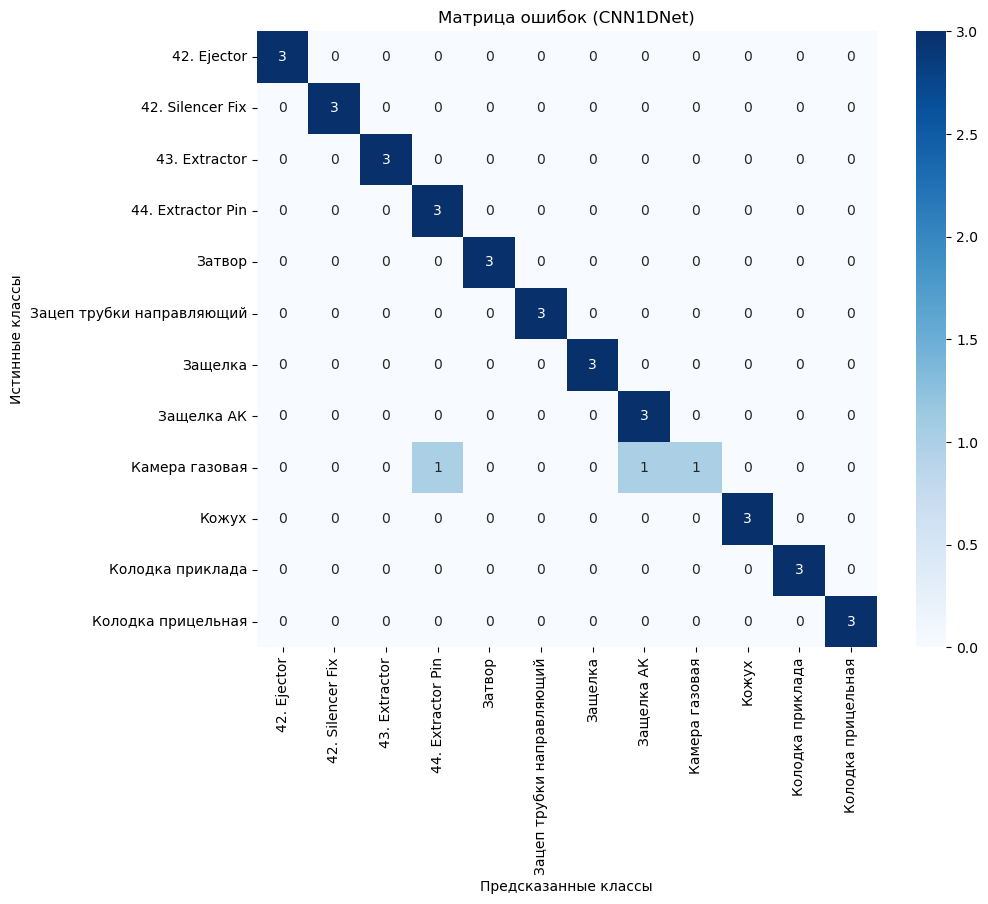

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test accuracy: {acc:.4f}")
print(f"Test F1 (weighted): {f1:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.inverse_transform(np.unique(y_true)),
            yticklabels=le.inverse_transform(np.unique(y_true)))
plt.title('Матрица ошибок (CNN1DNet)')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()